# Illumination Analysis 

#### 0. Setup

In [34]:
import sys
import os
import pickle
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import cosine_similarity 
from insightface.app import FaceAnalysis 
from tqdm import tqdm 
sys.path.append('/home/jferna27/project/stylegan2-ada-josefa')
import dnnlib 
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
torch.set_grad_enabled(False) 
torch.backends.cudnn.benchmark = False 
print("Using device:", device)

Using device: cuda:0


#### 2. Load StyleGAN2-ADA

In [36]:
network_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl" 
 
with dnnlib.util.open_url(network_url) as f: 
   G = pickle.load(f)["G_ema"].to(device).eval() 
 
print("Generator loaded")

Generator loaded


##### 2.1. Obama Projections Images

./docker_run.sh python3 projector.py --outdir=out_proj_obama/out_proj6 --target=illumination/obama_06.jpg --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl 

##### 2.2 Load Obama Projections

All imgs = same identity, different lighting

7 illuminations

In [37]:
proj_root = "../../stylegan2-ada-josefa/out_proj_obama"
w_plus_list = []

for root, dirs, files in os.walk(proj_root):
    for file in sorted(files):
        if file.endswith(".npz"):
            w = np.load(os.path.join(root, file))["w"]  # (1,18,512)
            w_plus_list.append(torch.tensor(w, device=device))

print("Loaded projections:", len(w_plus_list))

Loaded projections: 7


##### 3.  Obtain Illumination Direction (GANSpace / PCA) 

find the direcion in W+ who most change the illumination. THen use it to generate controlled variations

In [38]:
#generates random smaples in W+ of stylegan2-ada using PCA
N = 2000 
z = torch.randn([N, G.z_dim], device=device) 
w = G.mapping(z, None)# (N,18,512) 
w_np = w.cpu().numpy() 
w_flat = w_np.reshape(N, -1) # (N, 18*512) 
#pca find the directions of max variance in W+ (components[0])
pca = PCA(n_components=10) 
pca.fit(w_flat) 
dir_light = pca.components_[0] 

#normalize
dir_light = dir_light / np.linalg.norm(dir_light)  
dir_light = torch.tensor(dir_light, device=device).view(1,18,512) 
print("Illumination direction ready")

Illumination direction ready


#### 4.Generate Controlled Synthetic Images 

In [39]:
alphas = [-3, -2, -1, 0, 1, 2, 3] #7 values to multiple dir_light, alpha0 baseline
 
def synthesize(w_plus): #generates img
   img = G.synthesis(w_plus, noise_mode="const") 
   return (img + 1) / 2 
generated = [] 
 
for idx, w0 in enumerate(tqdm(w_plus_list, desc="Obama identities")): #varies the illumination
   w_id = w0.mean(dim=1, keepdim=True) 
   w_id = w_id.repeat(1,18,1) 
   for alpha in alphas: 
       w_mod = w_id + alpha * dir_light 
       img = synthesize(w_mod) 
       generated.append((idx, alpha, img.cpu()))

Obama identities:   0%|          | 0/7 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Warning: about that the system cannot find nvcc CUDA compiler, pytorch then falls back to a slow python/c++ implementation

In [40]:
print("generated", generated)

generated [(0, -3, tensor([[[[0.4378, 0.3729, 0.3147,  ..., 0.2462, 0.2406, 0.2317],
          [0.3473, 0.2971, 0.2780,  ..., 0.2704, 0.2570, 0.2011],
          [0.2964, 0.2870, 0.2826,  ..., 0.2624, 0.2579, 0.2215],
          ...,
          [0.1898, 0.1818, 0.2328,  ..., 0.2159, 0.2251, 0.2356],
          [0.2683, 0.2222, 0.2461,  ..., 0.2100, 0.2222, 0.2327],
          [0.4921, 0.2861, 0.2168,  ..., 0.1975, 0.2305, 0.2696]],

         [[0.4343, 0.3574, 0.3151,  ..., 0.2755, 0.2750, 0.2599],
          [0.3535, 0.2940, 0.2792,  ..., 0.2742, 0.2646, 0.2265],
          [0.3022, 0.2803, 0.2781,  ..., 0.2607, 0.2555, 0.2419],
          ...,
          [0.2209, 0.2127, 0.2456,  ..., 0.2067, 0.2165, 0.2451],
          [0.2920, 0.2751, 0.2877,  ..., 0.2118, 0.2194, 0.2522],
          [0.5261, 0.3440, 0.2679,  ..., 0.2217, 0.2566, 0.2836]],

         [[0.3933, 0.3122, 0.2892,  ..., 0.2791, 0.2798, 0.2652],
          [0.3468, 0.2884, 0.2771,  ..., 0.2656, 0.2609, 0.2365],
          [0.3048, 0.28

#### 5. Extract Embeddings

In [54]:
# MTCNN + FaceNet
print("Loading MTCNN for face detection...")
device = torch.device('cpu')
mtcnn = MTCNN(keep_all=True, device=device)

print("Loading FaceNet (InceptionResnetV1) for embeddings...")
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def get_embedding_mtcnn_facenet(img_tensor):
    img_np = (img_tensor[0].permute(1,2,0).numpy() * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_np)  
    try:
        #detection with MTCNN
        boxes, probs = mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0 and probs is not None:
            #face with  higher prob
            best_idx = np.argmax(probs)
            #obtain faces using MTCNN with cropping
            img_cropped_list = mtcnn(img_pil, return_prob=False)
            if img_cropped_list is not None and len(img_cropped_list) > best_idx:
                face_tensor = img_cropped_list[best_idx:best_idx+1] 
                #obtain embedding with FaceNet
                with torch.no_grad():
                    embedding = facenet(face_tensor.to(device))
                return embedding.cpu().numpy()[0]
        return None
    except Exception as e:
        return None

#extract embeddings from all imgs
print("\nExtracting embeddings from all generated images...")
embeddings = []
failed_count = 0
for (i, alpha, img) in tqdm(generated, desc="Embeddings"):
    emb = get_embedding_mtcnn_facenet(img)
    if emb is not None:
        embeddings.append((i, alpha, emb))
    else:
        failed_count += 1

print(f"\nTotal embeddings extracted: {len(embeddings)}")
print(f"Imgs without detected faces: {failed_count}")


Loading MTCNN for face detection...
Loading FaceNet (InceptionResnetV1) for embeddings...

Extracting embeddings from all generated images...


Embeddings: 100%|██████████| 49/49 [00:08<00:00,  6.04it/s]


Total embeddings extracted: 49
Imgs without detected faces: 0


- MTCNN: detected all faces in 49 generated imgs (0 errors)
- FaceNet (InceptionResnetV1): extract embeddings of 512D for each face

#### 6.Embedding Displacements

In [42]:
base_emb = {} #save baseline embeddings
for (i, alpha, emb) in embeddings: 
   if alpha == 0: 
       base_emb[i] = emb 
 
deltas = [] #calculate normalized displacement
for (i, alpha, emb) in embeddings: 
   if alpha != 0 and i in base_emb: 
       d = emb - base_emb[i] 
       d = d / np.linalg.norm(d) 
       deltas.append(d)

#### 7. Directional Consstency H1

In [55]:
sims = [] #measure if all the changes of illumination points out in the same direction in the embeddings space
for i in range(len(deltas)): 
   for j in range(i+1, len(deltas)): 
       sims.append(cosine_similarity(deltas[i].reshape(1,-1), deltas[j].reshape(1,-1))[0,0]) #measure the angle between 2 vectors

print("cos",sims)
print(len(sims))
print("H1 (mean directional consistency):", np.mean(sims)) 

cos [0.8259547, 0.67159617, -0.13803947, -0.3305223, -0.38483053, 0.08372286, 0.36794657, 0.46910307, -0.5725787, -0.28433233, -0.3513287, 0.04713939, 0.026429616, -0.096745335, -0.112373225, -0.168894, -0.32974488, 0.3633533, 0.3182678, 0.33188894, -0.21307199, -0.33074838, -0.38153633, 0.12057607, -0.1168142, -0.12242529, 0.07782254, -0.056881562, -0.26220602, 0.5150627, 0.46608424, 0.44321328, 0.12201522, 0.013119478, 0.122197844, 0.5833037, 0.6022583, 0.4908653, 0.12745999, 0.095230564, -0.13422175, 0.7445768, 0.16144112, -0.11974263, -0.19135593, 0.06576387, 0.38102084, 0.42174602, -0.619247, -0.40146166, -0.5384888, 0.021163786, -0.027518393, -0.19709536, -0.17399019, -0.16087224, -0.29298797, 0.37659362, 0.25496456, 0.3325484, -0.1291356, -0.36961228, -0.39444828, -0.07139008, -0.32686692, -0.28210837, 0.14063609, -0.049066477, -0.30753317, 0.48738688, 0.3320661, 0.41616744, 0.10956524, -0.004395902, 0.05136744, 0.49351507, 0.41728184, 0.34755075, -0.058915876, 0.033076912, -0.2

If H1 >0.3, strong evidence illumination is in a global consistent axis
- H1 0.04, deltas dispersed, H1 dont supported, the illumination dont form a unique direction in the embedding space

- cos=1 both deltas points out in the same direction
- cos=0 there are perpendicular (without directional relation)
- cos=-1 opposites directions

#### 8. identity vs Illumination Orthogonality (H2) 

In [44]:
id_vectors = [] 
for i in range(len(base_emb)-1): #caculates how much change the embeddings to pass to one identity to another
   v = base_emb[i+1] - base_emb[i] 
   id_vectors.append(v / np.linalg.norm(v)) 
 
illum_dir = np.mean(deltas, axis=0) #average direction of illumination
 
cos_id_light = cosine_similarity(np.mean(id_vectors, axis=0).reshape(1,-1), illum_dir.reshape(1,-1))[0,0] 
 
print("Identity vs Illumination cosine:", cos_id_light) 

Identity vs Illumination cosine: 0.044242173


- cos= identity and illumination are orthogonals(independents)= H2 supported

#### 9. Visualizations

Histogram of alineation, how every displacement aligns with the average direction of illumination (illum_dir)

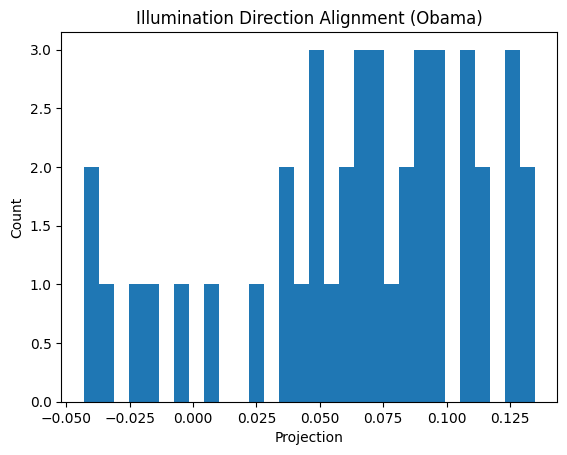

In [45]:
plt.hist( [d @ illum_dir for d in deltas], bins=30) 
plt.title("Illumination Direction Alignment (Obama)") 
plt.xlabel("Projection") 
plt.ylabel("Count") 
plt.show() 

projection betwwen -0.02 and 0.12 without a dominant peak. THere is not common direction H1=0 approx

### Results Interpretation
- H1: If the mean directional consistency is close to 0 (and low variance), illumination edits do not form a single global direction in embedding space. Higher positive values (e.g., >0.3) would indicate stronger alignment.
- H2: If the cosine between identity and illumination directions is near 0, the effects are approximately orthogonal. 


#### 10. Extract Illumination Direction from Real Obama Projections

In [57]:
#stack all Obama W+ vectors
obama_w_stack = torch.stack(w_plus_list, dim=0)  # (7, 1, 18, 512)
obama_w_np = obama_w_stack.squeeze(1).cpu().numpy()  # (7, 18, 512)
obama_w_flat = obama_w_np.reshape(7, -1)  # (7, 18*512)

#PCA on the 7 Obama illuminations
pca_obama = PCA(n_components=min(7, obama_w_flat.shape[0]))
pca_obama.fit(obama_w_flat)
#first component should capture the main variance = illumination
dir_light_obama = pca_obama.components_[0]
dir_light_obama = dir_light_obama / np.linalg.norm(dir_light_obama)
dir_light_obama = torch.tensor(dir_light_obama, device=w_plus_list[0].device).view(1, 18, 512)

print(f"Explained variance ratio (Obama PCA): {pca_obama.explained_variance_ratio_}")
print(f"First component explains {pca_obama.explained_variance_ratio_[0]*100:.1f}% of variance")
print(F"illumination direction: {dir_light_obama}")

Explained variance ratio (Obama PCA): [3.4965709e-01 2.0007437e-01 1.4076298e-01 1.3227582e-01 9.1953561e-02
 8.5276179e-02 4.2211373e-13]
First component explains 35.0% of variance
illumination direction: tensor([[[-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110],
         [-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110],
         [-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110],
         ...,
         [-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110],
         [-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110],
         [-0.0185,  0.0105,  0.0015,  ..., -0.0111,  0.0269,  0.0110]]],
       device='cuda:0')


#### 11. Regenerate images with Obama-derived illumination direction...


Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

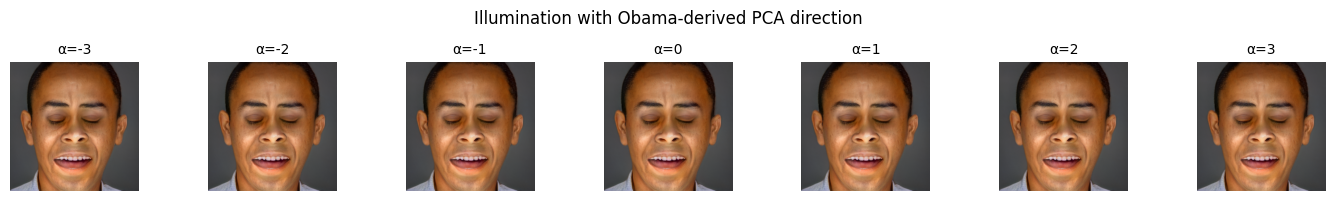

In [47]:
#generate new images using Obama-derived illumination direction
alphas_test = [-3, -2, -1, 0, 1, 2, 3]
generated_obama = []

w_test = w_plus_list[0]
w_id_test = w_test.mean(dim=1, keepdim=True).repeat(1, 18, 1)
for alpha in alphas_test:
    w_mod = w_id_test + alpha * dir_light_obama
    img = synthesize(w_mod)
    generated_obama.append((0, alpha, img.cpu()))

fig, axes = plt.subplots(1, len(alphas_test), figsize=(14, 2))
for j, alpha in enumerate(alphas_test):
    img_tensor = generated_obama[j][2]
    img_np = img_tensor[0].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    axes[j].imshow(img_np)
    axes[j].set_title(f'α={alpha}', fontsize=10)
    axes[j].axis('off')

plt.suptitle('Illumination with Obama-derived PCA direction', fontsize=12)
plt.tight_layout()
plt.show()

Even with Obama-derived PCA, no illumination changes are visible. This is because averaging `w_id` erases the original illumination information.

#### 12. Synthesize Original Obama Projections

Directly synthesize the original Obama projections (without averaging) to verify real illumination differences exist.

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

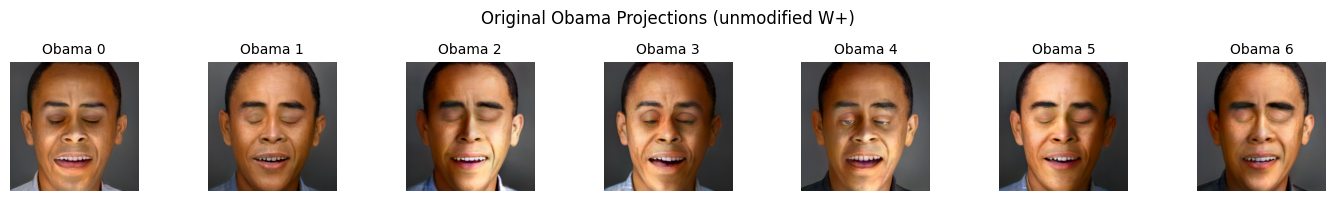

In [48]:
#synthesize the original 7 Obama W+ projections WITHOUT modification to verify they have different illumination
obama_originals = []
for i, w_plus in enumerate(w_plus_list):
    img = synthesize(w_plus)
    obama_originals.append((i, img.cpu()))
fig, axes = plt.subplots(1, len(obama_originals), figsize=(14, 2))
for j, (idx, img_tensor) in enumerate(obama_originals):
    img_np = img_tensor[0].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    axes[j].imshow(img_np)
    axes[j].set_title(f'Obama {j}', fontsize=10)
    axes[j].axis('off')

plt.suptitle('Original Obama Projections (unmodified W+)', fontsize=12)
plt.tight_layout()
plt.show()

#### 13. Use Direct Difference Between Two Obama Projections

Instead of PCA-> direct vector difference between the brightest and darkest Obama projections as illumination direction


Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

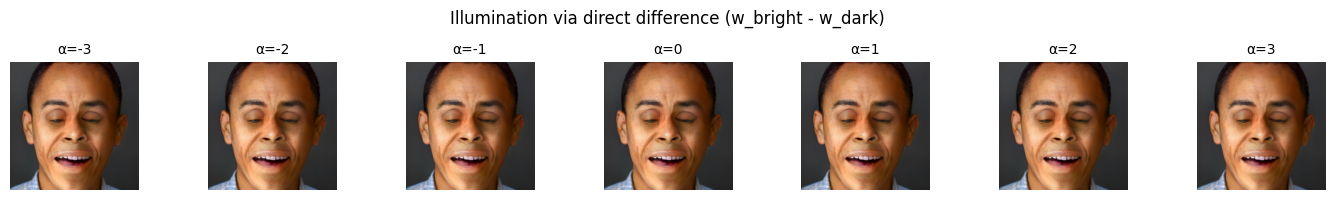

In [49]:
#obama_0 = darkest illumination, obama_6 = brightest
w_dark = w_plus_list[0]
w_bright = w_plus_list[-1]  # last one
#direction = difference between bright and dark
dir_illum_direct = (w_bright - w_dark)
dir_illum_direct = dir_illum_direct / torch.norm(dir_illum_direct)

#mid-point Obama as base identity
w_base = w_plus_list[3]  # middle Obama

#generate variations
alphas_direct = [-3, -2, -1, 0, 1, 2, 3]
generated_direct = []
for alpha in alphas_direct:
    w_mod = w_base + alpha * dir_illum_direct
    img = synthesize(w_mod)
    generated_direct.append((alpha, img.cpu()))
fig, axes = plt.subplots(1, len(alphas_direct), figsize=(14, 2))
for j, (alpha, img_tensor) in enumerate(generated_direct):
    img_np = img_tensor[0].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[j].imshow(img_np)
    axes[j].set_title(f'α={alpha}', fontsize=10)
    axes[j].axis('off')

plt.suptitle('Illumination via direct difference (w_bright - w_dark)', fontsize=12)
plt.tight_layout()
plt.show()

#### 14. Extract Embeddings from Original Obama Projections

In [ ]:
#calculate luminance for each original Obama image
luminances = []
for i, w_plus in enumerate(w_plus_list):
    img = synthesize(w_plus)
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    # Luminance = 0.299*R + 0.587*G + 0.114*B (from: https://www.sciencedirect.com/topics/computer-science/luminance-component)
    lum = 0.299 * img_np[:,:,0] + 0.587 * img_np[:,:,1] + 0.114 * img_np[:,:,2]
    mean_lum = lum.mean()
    luminances.append(mean_lum)
    print(f"Obama {i}: luminance = {mean_lum:.4f}")

#extract embeddings from original Obama images
embeddings_obama_orig = []
for i, w_plus in enumerate(tqdm(w_plus_list, desc="Extract embeddings from Obama originals")):
    img = synthesize(w_plus)
    emb = get_embedding_mtcnn_facenet(img.cpu())  # Move to CPU for embedding extraction
    if emb is not None:
        embeddings_obama_orig.append((i, luminances[i], emb))

print(f"\nExtracted {len(embeddings_obama_orig)} embeddings from original Obamas")

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Obama 0: luminance = 0.3740
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch p

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Obama 5: luminance = 0.3682
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up P

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Obama 6: luminance = 0.3908


Extract embeddings from Obama originals:   0%|          | 0/7 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!


/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!


Extract embeddings from Obama originals:  86%|████████▌ | 6/7 [00:01<00:00,  4.75it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Failed!


Extract embeddings from Obama originals: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]


Extracted 7 embeddings from original Obamas


In [51]:
#analyze correlation between luminance and embedding displacement
#darkest as reference
emb_ref_idx = np.argmin(luminances)
emb_ref = embeddings_obama_orig[emb_ref_idx][2]

#deltas from darkest to each other
deltas_real = []
lum_diffs = []

for (i, lum, emb) in embeddings_obama_orig:
    if i != emb_ref_idx:
        delta = emb - emb_ref
        delta = delta / (np.linalg.norm(delta) + 1e-8)
        deltas_real.append(delta)
        lum_diffs.append(lum - luminances[emb_ref_idx])

#seeing all deltas point in same direction (H1 for real illumination)
sims_real = []
for i in range(len(deltas_real)):
    for j in range(i+1, len(deltas_real)):
        sim = cosine_similarity(deltas_real[i].reshape(1,-1), deltas_real[j].reshape(1,-1))[0,0]
        sims_real.append(sim)

print(f"\n=== H1 for REAL Obama illumination changes ===")
print(f"H1 (mean directional illumination consistency): {np.mean(sims_real)}")
print(f"\nIf H1_real > 0.3, real illumination forms a consistent direction in embedding space.")
print(f"If H1_real ≈ 0, illumination doesn't map to a single axis even with real photos.")


=== H1 for REAL Obama illumination changes ===
H1 (mean directional illumination consistency): 0.5818559527397156

If H1_real > 0.3, real illumination forms a consistent direction in embedding space.
If H1_real ≈ 0, illumination doesn't map to a single axis even with real photos.


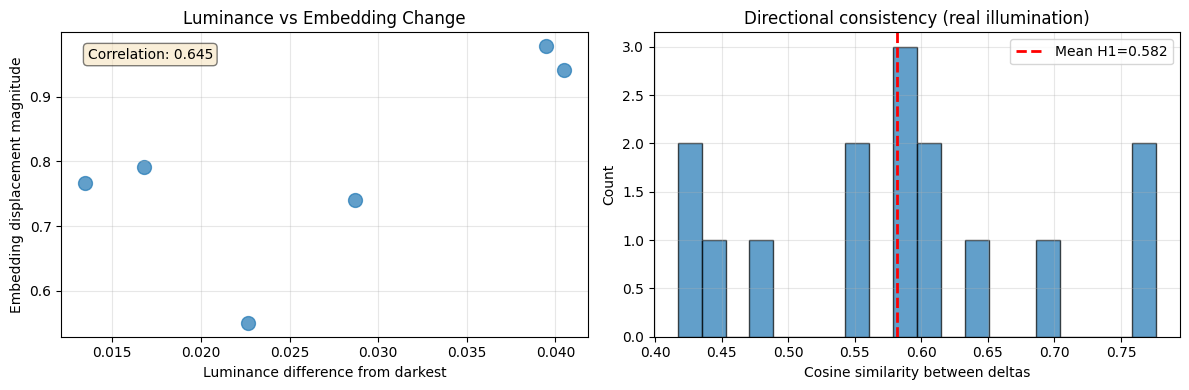

In [52]:
#visualize:luminance vs embedding displacement magnitude
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#Luminance vs Delta Magnitude
delta_mags = [np.linalg.norm(emb - emb_ref) for (i, lum, emb) in embeddings_obama_orig if i != emb_ref_idx]
ax1.scatter(lum_diffs, delta_mags, s=100, alpha=0.7)
ax1.set_xlabel('Luminance difference from darkest')
ax1.set_ylabel('Embedding displacement magnitude')
ax1.set_title('Luminance vs Embedding Change')
ax1.grid(True, alpha=0.3)
#correlation
if len(lum_diffs) > 1:
    corr = np.corrcoef(lum_diffs, delta_mags)[0,1]
    ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#pairwise cosine similarities
ax2.hist(sims_real, bins=20, alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(sims_real), color='red', linestyle='--', linewidth=2, label=f'Mean H1={np.mean(sims_real):.3f}')
ax2.set_xlabel('Cosine similarity between deltas')
ax2.set_ylabel('Count')
ax2.set_title('Directional consistency (real illumination)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plu

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jferna27/project/stylegan2-ada-josefa/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/jferna27/.local/lib/python3.11/site-packages/torch/utils/cpp_ex

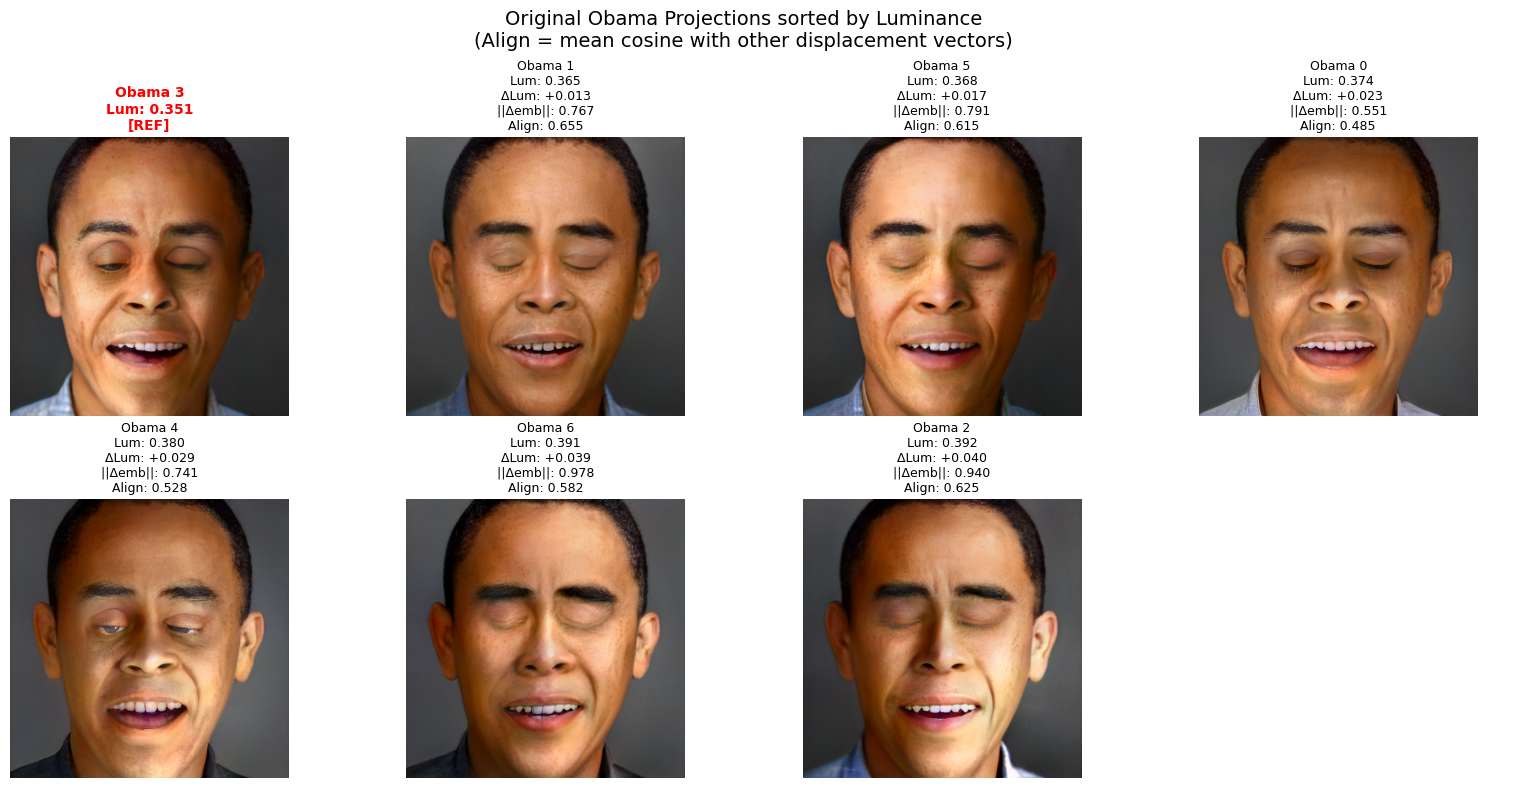

In [53]:
#visualize Original Obama Images sorted by Luminance
#images + luminance values + displacement info
sorted_indices = np.argsort(luminances)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for plot_idx, obama_idx in enumerate(sorted_indices):
    if plot_idx >= 7:
        break
    img = synthesize(w_plus_list[obama_idx])
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)
    #embedding displacement from darkest
    if obama_idx != emb_ref_idx:
        emb_current = embeddings_obama_orig[obama_idx][2]
        delta_mag = np.linalg.norm(emb_current - emb_ref)
        lum_diff = luminances[obama_idx] - luminances[emb_ref_idx]
        #cosine with respect to other deltas (consistency)
        delta_normalized = (emb_current - emb_ref) / (np.linalg.norm(emb_current - emb_ref) + 1e-8)
        cos_with_others = []
        for other_idx in sorted_indices:
            if other_idx != obama_idx and other_idx != emb_ref_idx:
                emb_other = embeddings_obama_orig[other_idx][2]
                delta_other = (emb_other - emb_ref) / (np.linalg.norm(emb_other - emb_ref) + 1e-8)
                cos = cosine_similarity(delta_normalized.reshape(1,-1), delta_other.reshape(1,-1))[0,0]
                cos_with_others.append(cos)
        mean_cos = np.mean(cos_with_others) if len(cos_with_others) > 0 else 0.0
    else:
        delta_mag = 0.0
        lum_diff = 0.0
        mean_cos = 1.0
    
    axes[plot_idx].imshow(img_np)
    axes[plot_idx].axis('off')
    info_text = f"Obama {obama_idx}\nLum: {luminances[obama_idx]:.3f}"
    if obama_idx == emb_ref_idx:
        info_text += "\n[REF]"
        axes[plot_idx].set_title(info_text, fontsize=10, color='red', weight='bold')
    else:
        info_text += f"\nΔLum: {lum_diff:+.3f}\n||Δemb||: {delta_mag:.3f}\nAlign: {mean_cos:.3f}"
        axes[plot_idx].set_title(info_text, fontsize=9)

if len(sorted_indices) == 7:
    axes[7].axis('off')

plt.suptitle('Original Obama Projections sorted by Luminance\n(Align = mean cosine with other displacement vectors)', fontsize=14)
plt.tight_layout()
plt.show()

#### Conclusion

- Illumination is NOT linearly encoded in StyleGAN2-ADA W+ latent space.


ALL attempts to generate illumination variations via linear W+ manipulation failed:
   - Random PCA (`pca.components_[0]`)
   - Obama-specific PCA (`pca_obama.components_[0]`)
   - Direct difference (`w_bright - w_dark`)